In [1]:
import pandas as pd
import numpy as np 
import pickle5
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
with open("../data/ut_poiV6.pkl", "rb") as fh:
    df = pickle5.load(fh)
    
df.head(3)

,life_time,datetime_start,datetime_end,latitude,longitude,distance_center_km,Station_Name,weekday_b,weekday_b_name,hour_b,...,near_inactivity_6H,near_charge_events_6H,service,entertainment,food,childcare,medical,education,parking,waste-management
0,928.5,2018-01-31 19:51:00,2018-02-01 11:19:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,2,Wednesday,19,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959
1,363.5,2018-02-01 14:03:00,2018-02-01 20:06:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,3,Thursday,14,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959
2,6828.5,2018-02-01 21:15:00,2018-02-06 15:03:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,3,Thursday,21,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959


In [3]:
df.shape

(12711, 71)

### Remove outliers & nan

In [ ]:
# remove rows
df = df.dropna()

In [7]:
# remove outliers
drop_index = [] # list of indexes to keep
names = df['Station_Name'].unique()

for name in names:
    temp = df[df['Station_Name'] == name]
    # Get interquantile ranges
    Q1, Q3 = temp.life_time.quantile([0.25, 0.75])
    IQR = Q3-Q1
    minimum = Q1 - 1.5*IQR
    maximum = Q3 + 1.5*IQR
    # Define observations which should be removed
    temp2 = df[(df['life_time'] < minimum) | (df['life_time'] > maximum) &
                  (df['Station_Name'] == name)]
    print("{n}: {s} ({p} %)".format(n=name, 
                                    s=temp2.shape[0], 
                                    p=round((temp2.shape[0]/temp.shape[0])*100,2)))
    # Add the indexes which should be dropped
    drop_index.extend(list(temp2.index))
    
print("\nThe total amount of lost events: {n} ({p} %)".format(n=len(drop_index), 
                                                              p=round(len(drop_index)/df.shape[0]*100,2)))

df = df.drop(drop_index)
df = df.reset_index(drop=True)

COMM VITALITY / 1104 SPRUCE1: 57 (4.4 %)
COMM VITALITY / 1000WALNUT: 48 (3.32 %)
BOULDER / REC CENTER: 40 (3.51 %)
BOULDER / BASELINE ST1: 42 (3.53 %)
BOULDER / ATRIUM ST1: 65 (6.58 %)
BOULDER / ALPINE ST1: 32 (8.96 %)
COMM VITALITY / 1400 WALNUT1: 38 (7.29 %)
BOULDER / FACILITIES ST1: 84 (16.28 %)
COMM VITALITY / 1500PEARL: 41 (4.5 %)
BOULDER / JUNCTION ST1: 35 (9.97 %)
COMM VITALITY / BOULDER JCTN: 40 (5.28 %)
COMM VITALITY / 1100WALNUT1: 39 (3.51 %)
BOULDER / N BOULDER REC 1: 29 (2.07 %)
BOULDER / BOULDER PARK: 8 (4.55 %)
COMM VITALITY / 2200 BROADWAY1: 0 (0.0 %)
BOULDER / EAST REC: 23 (5.42 %)
BOULDERJUNCTION / JUNCTION ST1: 3 (3.0 %)

The total amount of lost events: 624 (4.91 %)


In [8]:
df.shape

(12075, 71)

### Focus stations

In [9]:
station_subset = ['BOULDER / N BOULDER REC 1', 'COMM VITALITY / 1000WALNUT', 
        'COMM VITALITY / 1104 SPRUCE1', 'BOULDER / BASELINE ST1']

df = df[df['Station_Name'].isin(station_subset)]

### Modeling functions

In [10]:
## To test model
def test_model(y_test, y_pred):
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    print('MAE (Mean Absolute Error):', MAE)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    print('MSE (Mean Squared Error):', MSE)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print('RMSE (Root Mean Squared Error):', RMSE)
    return MAE, RMSE, MSE

In [12]:
def hour_label(X):
    if (X >= 7) & (X <= 10):
        return 'Morning'
    elif (X >= 11) & (X <= 14):
        return 'Midday'
    elif (X >= 15) & (X <= 18):
        return 'Afternoon'
    elif (X >= 19) or (X < 1):
        return 'Evening'
    elif (X >= 1) & (X <= 6):
        return 'Night'

In [13]:
df['tod'] = df['hour_b'].apply(hour_label)

In [14]:
df = df[df['tod'] != 'Night']

### Adding dummies
We define `X`, the features, `T`, the time column and `E` the event columns. First though we need to dummify the categorical variables.

In [15]:
df_copy = df.copy()

In [16]:
# Categorical features
columns_categorical = ['weekday_b_name','tod','hour_b','Station_Name']

In [17]:
df = pd.get_dummies(df, columns=columns_categorical, drop_first=True)

### Add split binary variable

In [18]:
def hsplit(X):
    if X >= 4*60:
        return 1
    else:
        return 0

In [19]:
df['4Hsplit'] = df['life_time'].apply(hsplit)

## Modeling features

To make coding easier the names of the models are changed:
- M1: Baseline
- M5: Full

In [20]:
## M1
features1 = ['weekday_b_name_Monday', 'weekday_b_name_Saturday',
             'weekday_b_name_Sunday', 'weekday_b_name_Thursday',
             'weekday_b_name_Tuesday', 'weekday_b_name_Wednesday',
             'tod_Evening','tod_Midday', 'tod_Morning',
             'Station_Name_BOULDER / N BOULDER REC 1',
             'Station_Name_COMM VITALITY / 1000WALNUT',
             'Station_Name_COMM VITALITY / 1104 SPRUCE1'] # dow + tod

## M5
features5_cat = ['weekday_b_name_Monday', 'weekday_b_name_Saturday',
                 'weekday_b_name_Sunday', 'weekday_b_name_Thursday',
                 'weekday_b_name_Tuesday', 'weekday_b_name_Wednesday',
                 'tod_Evening','tod_Midday', 'tod_Morning',
                 'Station_Name_BOULDER / N BOULDER REC 1',
                 'Station_Name_COMM VITALITY / 1000WALNUT',
                 'Station_Name_COMM VITALITY / 1104 SPRUCE1']
features5_con = ['lag1', 'lag2', 'lag3','near_charge_time_4H', 'near_charge_energy_4H',
                 'charge_time_4H', 'charge_energy_4H','service', 'entertainment', 'food', 
                 'childcare', 'medical', 'education','parking', 'waste-management'] # dow + agg. tod + lag + activ.

In [21]:
# dictionary to save results in 
results = {}

split = 0.8
b_params = {}

#### Evaluation metrics

In [22]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score,classification_report, f1_score
from sklearn.metrics import plot_confusion_matrix

# function to evaluate predictions
def confusion_ma(y_true, y_pred):
    # calculate and display confusion matrix
    labels = np.unique(y_true)
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(y_true, y_pred,normalize=True)
    return plt.show()

In [24]:
# function to evaluate only accuracy, precision, recall and f1 score
def evaluate_scores(y_true, y_pred):
    # calculate confusion matrix
    labels = np.unique(y_true)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    # calculate precision, recall, and F1 score
    accuracy = float(np.trace(cm)) / np.sum(cm)
    precision = precision_score(y_true, y_pred, average=None, labels=labels)[1]
    recall = recall_score(y_true, y_pred, average=None, labels=labels)[1]
    f1 = 2 * precision * recall / (precision + recall)
    print("accuracy:", round(accuracy,2))
    print("precision:", round(precision,2))
    print("recall:", round(recall,2))
    print("f1 score:", round(f1,2))
    return accuracy, precision, recall, f1

### Check test and train data

In [25]:
df = df.sort_values(by=['datetime_start'])

In [26]:
y = df['4Hsplit']
y_train, y_test = np.split(y, [int(split*len(df))])
class_names = ['SHORT (< 4H)', 'LONG (>= 4H)']

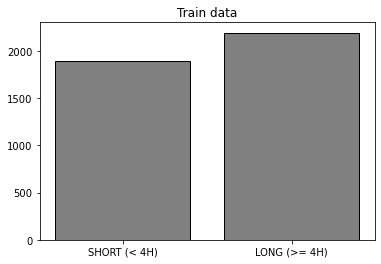

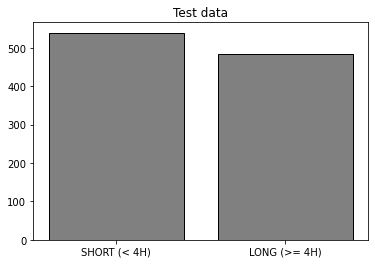

In [27]:
# Train
temp = np.unique(y_train, return_counts=True)
plt.bar(class_names, temp[1], color='grey', edgecolor='k')
plt.title("Train data")
plt.show()

# Test
temp = np.unique(y_test, return_counts=True)
plt.bar(class_names, temp[1], color='grey', edgecolor='k')
plt.title("Test data")
plt.show()

An data imbalance is noticed. Therefore the `f1_micro` is used at scoring metric as this should try and take the imbalance into account.

In [28]:
bob = df.groupby(['4Hsplit']).count()['life_time']
summ = bob[0]+bob[1]
print("Combined data:   SHORT: {}% ({})  LONG: {}% ({})".format(round(bob[0]/summ,2),bob[0],
                                                          round(bob[1]/summ,2),bob[1]))

bob = y_train.value_counts()
summ = bob[0]+bob[1]
print("train data:      SHORT: {}% ({})  LONG: {}% ({})".format(round(bob[0]/summ,2),bob[0],
                                                          round(bob[1]/summ,2),bob[1]))

bob = y_test.value_counts()
summ = bob[0]+bob[1]
print("test data:       SHORT: {}% ({})   LONG: {}% ({})".format(round(bob[0]/summ,2),bob[0],
                                                          round(bob[1]/summ,2),bob[1]))

Combined data:   SHORT: 0.48% (2434)  LONG: 0.52% (2676)
train data:      SHORT: 0.46% (1895)  LONG: 0.54% (2193)
test data:       SHORT: 0.53% (539)   LONG: 0.47% (483)


## Random forest classifier

In [30]:
results['RF'] = {}
grid = {'n_estimators':[100,300,500,1000], 'min_samples_split':[2,3,5,7],
           'min_samples_leaf':[3,5,10,15], 'max_depth':[2,3,5,7]}

#### RF - Model 1

{'n_estimators': 500, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_depth': 7}
accuracy: 0.73
precision: 0.75
recall: 0.66
f1 score: 0.7
              precision    recall  f1-score   support

SHORT (< 4H)       0.72      0.80      0.76       539
LONG (>= 4H)       0.75      0.66      0.70       483

    accuracy                           0.73      1022
   macro avg       0.73      0.73      0.73      1022
weighted avg       0.73      0.73      0.73      1022



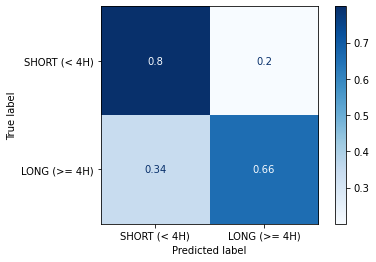

In [31]:
X = df[features1]
y = df['4Hsplit']
X_train, X_test = np.split(X, [int(split*len(df))])
y_train, y_test = np.split(y, [int(split*len(df))])

# Estimator
clf = RandomForestClassifier(random_state=42)

# RandomizedSearchCV
gs = RandomizedSearchCV(clf, grid, cv=5, random_state=42, 
                        n_iter=60, scoring='f1_micro')
search = gs.fit(X_train, y_train)

# Get best parameters
param = search.best_params_
print(param)

# Evaluate model
clf = RandomForestClassifier(random_state=42, n_estimators=param['n_estimators'],
                             max_depth=param['max_depth'], 
                             min_samples_leaf=param['min_samples_leaf'],
                             min_samples_split=param['min_samples_split'])
clf.fit(X_train,y_train)

#Results
y_pred = clf.predict(X_test) # make predictions
accuracy, precision, recall, f1 = evaluate_scores(y_test,y_pred)
print(classification_report(y_test, y_pred, target_names=class_names))
# get confusion matrix
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, 
                      display_labels=class_names, normalize='true')
plt.show()

# save results
results['RF']['M1'] = {'f1':f1, 'accuracy':accuracy, 'precision':precision, 'recall':recall,
                       'param': param}

#### RF - Model 5

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 15, 'max_depth': 7}
accuracy: 0.74
precision: 0.77
recall: 0.64
f1 score: 0.7
              precision    recall  f1-score   support

SHORT (< 4H)       0.72      0.83      0.77       539
LONG (>= 4H)       0.77      0.64      0.70       483

    accuracy                           0.74      1022
   macro avg       0.74      0.73      0.73      1022
weighted avg       0.74      0.74      0.74      1022



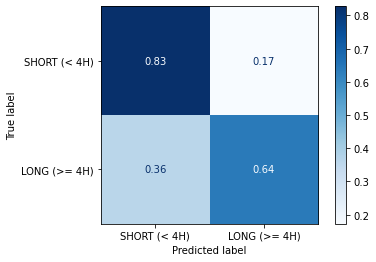

In [32]:
X = df[features5_cat+features5_con]
y = df['4Hsplit']
X_train, X_test = np.split(X, [int(split*len(df))])
y_train, y_test = np.split(y, [int(split*len(df))])

scaler = StandardScaler()
X_train[features5_con] = scaler.fit_transform(X_train[features5_con])
X_test[features5_con] = scaler.fit_transform(X_test[features5_con])

# Estimator
clf = RandomForestClassifier()

# RandomizedSearchCV
gs = RandomizedSearchCV(clf, grid, cv=5, random_state=42, 
                        n_iter=60, scoring='f1_micro')
search = gs.fit(X_train, y_train)

# Get best parameters
param = search.best_params_
print(param)

# Evaluate model
clf = RandomForestClassifier(random_state=42, n_estimators=param['n_estimators'],
                             max_depth=param['max_depth'], 
                             min_samples_leaf=param['min_samples_leaf'],
                             min_samples_split=param['min_samples_split'])
clf.fit(X_train,y_train)

#Results
y_pred = clf.predict(X_test) # make predictions
accuracy, precision, recall, f1 = evaluate_scores(y_test,y_pred)
print(classification_report(y_test, y_pred, target_names=class_names))
# get confusion matrix
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, 
                      display_labels=class_names, normalize='true')
plt.show()

# save results
results['RF']['M5'] = {'f1':f1, 'accuracy':accuracy, 'precision':precision, 'recall':recall,
                       'param': param}

## Gradient boosting classifier

In [33]:
results['GB'] = {}

grid = {'max_depth':[2,3,5,10],'n_estimators':[100,300,500,1000], 
           'learning_rate':[0.001,0.01,0.1,0.5,0.9], 'min_samples_split':[2,3,5,7],
           'min_samples_leaf':[3,5,10,15]}

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

#### GB - Model 1

{'n_estimators': 100, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_depth': 3, 'learning_rate': 0.5}
accuracy: 0.74
precision: 0.75
recall: 0.69
f1 score: 0.72
              precision    recall  f1-score   support

SHORT (< 4H)       0.74      0.79      0.76       539
LONG (>= 4H)       0.75      0.69      0.72       483

    accuracy                           0.74      1022
   macro avg       0.74      0.74      0.74      1022
weighted avg       0.74      0.74      0.74      1022



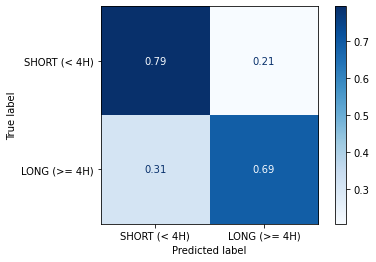

In [36]:
X = df[features1]
y = df['4Hsplit']
X_train, X_test = np.split(X, [int(split*len(df))])
y_train, y_test = np.split(y, [int(split*len(df))])

# Estimator
clf = GradientBoostingClassifier(random_state=42)

# RandomizedSearchCV
gs = RandomizedSearchCV(clf, grid, cv=5, random_state=42, 
                        n_iter=60, scoring='f1_micro')
search = gs.fit(X_train, y_train)

# Get best parameters
param = search.best_params_
print(param)

# Evaluate model
clf = GradientBoostingClassifier(random_state=42, 
                                max_depth=param['max_depth'],
                                min_samples_split=param['min_samples_split'],
                                min_samples_leaf=param['min_samples_leaf'],
                                n_estimators=param['n_estimators'], 
                                learning_rate=param['learning_rate'])
clf.fit(X_train,y_train)

#Results
y_pred = clf.predict(X_test) # make predictions
accuracy, precision, recall, f1 = evaluate_scores(y_test,y_pred)
print(classification_report(y_test, y_pred, target_names=class_names))
# get confusion matrix
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, 
                      display_labels=class_names, normalize='true')
plt.show()

# save results
results['GB']['M1'] = {'f1':f1, 'accuracy':accuracy, 'precision':precision, 'recall':recall,
                       'param': param}

#### GB - Model 5

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 3, 'learning_rate': 0.01}
accuracy: 0.76
precision: 0.8
recall: 0.65
f1 score: 0.71
              precision    recall  f1-score   support

SHORT (< 4H)       0.73      0.85      0.79       539
LONG (>= 4H)       0.80      0.65      0.71       483

    accuracy                           0.76      1022
   macro avg       0.76      0.75      0.75      1022
weighted avg       0.76      0.76      0.75      1022



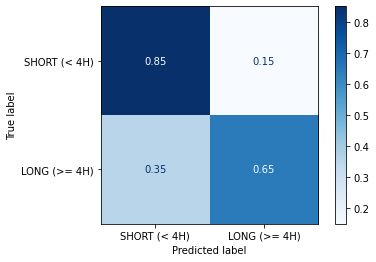

In [37]:
X = df[features5_cat+features5_con]
y = df['4Hsplit']
X_train, X_test = np.split(X, [int(split*len(df))])
y_train, y_test = np.split(y, [int(split*len(df))])

scaler = StandardScaler()
X_train[features5_con] = scaler.fit_transform(X_train[features5_con])
X_test[features5_con] = scaler.fit_transform(X_test[features5_con])


# Estimator
clf = GradientBoostingClassifier(random_state=42)

# RandomizedSearchCV
gs = RandomizedSearchCV(clf, grid, cv=5, random_state=42, 
                        n_iter=60, scoring='f1_micro')
search = gs.fit(X_train, y_train)

# Get best parameters
param = search.best_params_
print(param)

# Evaluate model
clf = GradientBoostingClassifier(random_state=42, 
                                max_depth=param['max_depth'],
                                min_samples_split=param['min_samples_split'],
                                min_samples_leaf=param['min_samples_leaf'],
                                n_estimators=param['n_estimators'], 
                                learning_rate=param['learning_rate'])
clf.fit(X_train,y_train)

#Results
y_pred = clf.predict(X_test) # make predictions
accuracy, precision, recall, f1 = evaluate_scores(y_test,y_pred)
print(classification_report(y_test, y_pred, target_names=class_names))
# get confusion matrix
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, 
                      display_labels=class_names, normalize='true')
plt.show()

# save results
results['GB']['M5'] = {'f1':f1, 'accuracy':accuracy, 'precision':precision, 'recall':recall,
                       'param': param}

In [ ]:
# Evaluate model
clf = GradientBoostingClassifier(random_state=42, 
                                max_depth=param['max_depth'],
                                min_samples_split=param['min_samples_split'],
                                min_samples_leaf=param['min_samples_leaf'],
                                n_estimators=param['n_estimators'], 
                                learning_rate=param['learning_rate'])
clf.fit(X_train,y_train)

{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 3, 'learning_rate': 0.01}

### Neural network /MLP


In [38]:
results['NN'] = {}
grid = {}

grid = {'alpha':[0.0001,0.001,0.1,1,2,5,10], 'hidden_layer_sizes':
            [(32),(32,32),(32,32),(32,32,32,32),(64),(64,64),(64,64,64),(64,64,64,64),
             (128),(128,128),(128,128,128),(128,128,128,128),(256),(256,256),(256,256,256),
             (256,256,256,256)],
            'activation': ['tanh', 'relu', 'logistic']}

In [39]:
from sklearn.neural_network import MLPClassifier

#### NN - Model 1

{'hidden_layer_sizes': 256, 'alpha': 0.001, 'activation': 'relu'}
accuracy: 0.74
precision: 0.77
recall: 0.64
f1 score: 0.7
              precision    recall  f1-score   support

SHORT (< 4H)       0.72      0.83      0.77       539
LONG (>= 4H)       0.77      0.64      0.70       483

    accuracy                           0.74      1022
   macro avg       0.74      0.73      0.73      1022
weighted avg       0.74      0.74      0.73      1022



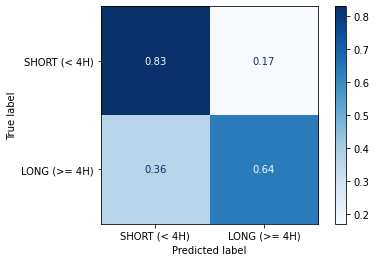

In [40]:
X = df[features1]
y = df['4Hsplit']
X_train, X_test = np.split(X, [int(split*len(df))])
y_train, y_test = np.split(y, [int(split*len(df))])

# Estimator
clf = MLPRegressor(random_state=42, max_iter=1000, early_stopping=True)

# RandomizedSearchCV
gs = RandomizedSearchCV(clf, grid, cv=5, random_state=42, 
                        max_iter=60, scoring='f1_micro')
search = gs.fit(X_train, y_train)

# Get best parameters
param = search.best_params_
print(param)

# Evaluate model
clf = MLPClassifier(random_state=42, alpha=param['alpha'], 
                   hidden_layer_sizes=param['hidden_layer_sizes'],
                   activation = param['activation'],max_iter=1000, early_stopping=True)
clf.fit(X_train,y_train)

#Results
y_pred = clf.predict(X_test) # make predictions
accuracy, precision, recall, f1 = evaluate_scores(y_test,y_pred)
print(classification_report(y_test, y_pred, target_names=class_names))
# get confusion matrix
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, 
                      display_labels=class_names, normalize='true')
plt.show()

# save results
results['NN']['M1'] = {'f1':f1, 'accuracy':accuracy, 'precision':precision, 'recall':recall,
                       'param': param}

#### NN - Model 5

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the

{'hidden_layer_sizes': (64, 64), 'alpha': 0.0001, 'activation': 'logistic'}


C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


accuracy: 0.67
precision: 0.65
recall: 0.66
f1 score: 0.66
              precision    recall  f1-score   support

SHORT (< 4H)       0.69      0.68      0.69       539
LONG (>= 4H)       0.65      0.66      0.66       483

    accuracy                           0.67      1022
   macro avg       0.67      0.67      0.67      1022
weighted avg       0.67      0.67      0.67      1022



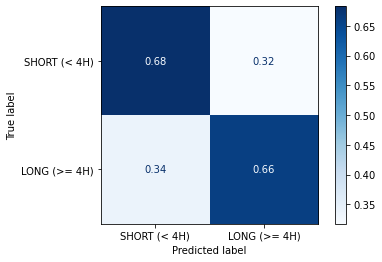

In [41]:
X = df[features5_cat+features5_con]
y = df['4Hsplit']
X_train, X_test = np.split(X, [int(split*len(df))])
y_train, y_test = np.split(y, [int(split*len(df))])

scaler = StandardScaler()
X_train[features5_con] = scaler.fit_transform(X_train[features5_con])
X_test[features5_con] = scaler.fit_transform(X_test[features5_con])


# Estimator
clf = MLPRegressor(random_state=42, max_iter=1000, early_stopping=True)

# RandomizedSearchCV
gs = RandomizedSearchCV(clf, grid, cv=5, random_state=42, 
                        max_iter=60, scoring='f1_micro')
search = gs.fit(X_train, y_train)

# Get best parameters
param = search.best_params_
print(param)

# Evaluate model
clf = MLPClassifier(random_state=42, alpha=param['alpha'], 
                   hidden_layer_sizes=param['hidden_layer_sizes'],
                   activation = param['activation'],max_iter=1000, early_stopping=True)
clf.fit(X_train,y_train)

#Results
y_pred = clf.predict(X_test) # make predictions
accuracy, precision, recall, f1 = evaluate_scores(y_test,y_pred)
print(classification_report(y_test, y_pred, target_names=class_names))
# get confusion matrix
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, 
                      display_labels=class_names, normalize='true')
plt.show()

# save results
results['NN']['M5'] = {'f1':f1, 'accuracy':accuracy, 'precision':precision, 'recall':recall,
                       'param': param}

### Logistic regression

In [42]:
results['LR'] = {}
grid = {'penalty':['l1','l2'] }

In [43]:
from sklearn.linear_model import LogisticRegression

#### LR - Model 1

C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2

{'penalty': 'l2'}
accuracy: 0.73
precision: 0.75
recall: 0.65
f1 score: 0.7
              precision    recall  f1-score   support

SHORT (< 4H)       0.72      0.80      0.76       539
LONG (>= 4H)       0.75      0.65      0.70       483

    accuracy                           0.73      1022
   macro avg       0.74      0.73      0.73      1022
weighted avg       0.73      0.73      0.73      1022



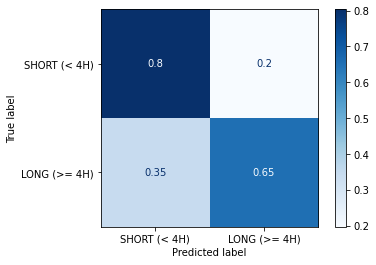

In [44]:
X = df[features1]
y = df['4Hsplit']
X_train, X_test = np.split(X, [int(split*len(df))])
y_train, y_test = np.split(y, [int(split*len(df))])

# Estimator
clf = LogisticRegression(random_state=42)

# RandomizedSearchCV
gs = RandomizedSearchCV(clf, grid, cv=5, random_state=42, scoring='f1_micro')
search = gs.fit(X_train, y_train)

# Get best parameters
param = search.best_params_
print(param)

# Evaluate model
clf = LogisticRegression(penalty=param['penalty'], random_state=42)
clf.fit(X_train,y_train)

#Results
y_pred = clf.predict(X_test) # make predictions
accuracy, precision, recall, f1 = evaluate_scores(y_test,y_pred)
print(classification_report(y_test, y_pred, target_names=class_names))
# get confusion matrix
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, 
                      display_labels=class_names, normalize='true')
plt.show()

# save results
results['LR']['M1'] = {'f1':f1, 'accuracy':accuracy, 
                       'recall':recall, 'precision':precision}

#### LR - Model 5

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


{'penalty': 'l2'}
accuracy: 0.73
precision: 0.75
recall: 0.65
f1 score: 0.7
              precision    recall  f1-score   support

SHORT (< 4H)       0.72      0.81      0.76       539
LONG (>= 4H)       0.75      0.65      0.70       483

    accuracy                           0.73      1022
   macro avg       0.74      0.73      0.73      1022
weighted avg       0.74      0.73      0.73      1022



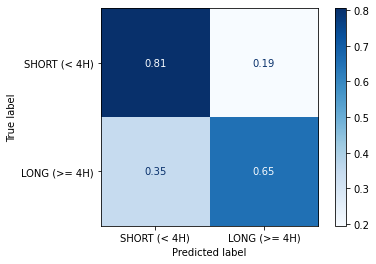

In [45]:
X = df[features5_cat+features5_con]
y = df['4Hsplit']
X_train, X_test = np.split(X, [int(split*len(df))])
y_train, y_test = np.split(y, [int(split*len(df))])

scaler = StandardScaler()
X_train[features5_con] = scaler.fit_transform(X_train[features5_con])
X_test[features5_con] = scaler.fit_transform(X_test[features5_con])


# Estimator
clf = LogisticRegression(random_state=42)

# Get best parameters
param = search.best_params_
print(param)

# Evaluate model
clf = LogisticRegression(penalty=param['penalty'], random_state=42)
clf.fit(X_train,y_train)

#Results
y_pred = clf.predict(X_test) # make predictions
accuracy, precision, recall, f1 = evaluate_scores(y_test,y_pred)
print(classification_report(y_test, y_pred, target_names=class_names))
# get confusion matrix
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, 
                      display_labels=class_names, normalize='true')
plt.show()

# save results
results['LR']['M5'] = {'f1':f1, 'accuracy':accuracy, 
                       'recall':recall, 'precision':precision}

### Results

#### Save results

In [63]:
models = ['M1','M5']

for m in results.keys():
    print(15*'-',m,15*'-')
    for M in results[m].keys():
        res = results[m][M]
        print("{}:   f1: {}   accuracy: {}   precision: {}   recall: {}".format(M,
              round(res['f1'],3), round(res['accuracy'],3), round(res['precision'],2),
              round(res['recall'],2)))

--------------- RF ---------------
M1:   f1: 0.7   accuracy: 0.733   precision: 0.75   recall: 0.66
M5:   f1: 0.698   accuracy: 0.739   precision: 0.77   recall: 0.64
--------------- GB ---------------
M1:   f1: 0.716   accuracy: 0.743   precision: 0.75   recall: 0.69
M5:   f1: 0.715   accuracy: 0.755   precision: 0.8   recall: 0.65
--------------- NN ---------------
M1:   f1: 0.696   accuracy: 0.738   precision: 0.77   recall: 0.64
M5:   f1: 0.656   accuracy: 0.672   precision: 0.65   recall: 0.66
--------------- LR ---------------
M1:   f1: 0.698   accuracy: 0.733   precision: 0.75   recall: 0.65
M5:   f1: 0.699   accuracy: 0.734   precision: 0.75   recall: 0.65


### Add classifier result to dataframe
Choose GB M5. Train model for all data.

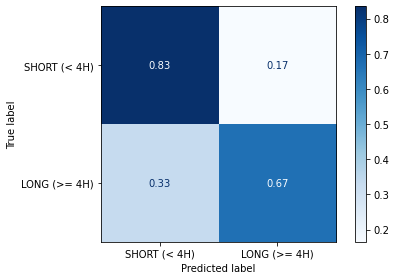

In [33]:
X = df[features5_cat+features5_con]
y = df['4Hsplit']
X_train, X_test = np.split(X, [int(split*len(df))])
y_train, y_test = np.split(y, [int(split*len(df))])

scaler = StandardScaler()
X_train[features5_con] = scaler.fit_transform(X_train[features5_con])
X_test[features5_con] = scaler.fit_transform(X_test[features5_con])


# Evaluate model
clf = GradientBoostingClassifier(random_state=42, 
                                max_depth=3,
                                min_samples_split=5,
                                min_samples_leaf=3,
                                n_estimators=500, 
                                learning_rate=0.01)
clf.fit(X_train,y_train)

#Results
y_pred_test = clf.predict(X_test) # make predictions
y_pred_train = clf.predict(X_train)

plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, 
                      display_labels=class_names, normalize='true')
plt.tight_layout()
plt.savefig("../Thesis - writing/Visualization/confusionMatrix4H.pdf")
plt.show()

Add predicted train and test to the original dataframe.

In [65]:
X_test['y_pred'] = y_pred_test
X_train['y_pred'] = y_pred_train

In [37]:
coefs = clf.feature_importances_
names = X_train.columns
fea_impor = pd.DataFrame(columns=['fea','coef'])
fea_impor['fea'] = names
fea_impor['coef'] = coefs

In [42]:
fea_impor.sort_values(by=['coef'],ascending=False)[0:10]

,fea,coef
6,tod_Evening,0.665226
14,lag3,0.039020
13,lag2,0.036695
26,waste-management,0.033764
17,charge_time_4H,0.031334
12,lag1,0.025396
23,medical,0.022092
21,food,0.022030
18,charge_energy_4H,0.019895
8,tod_Morning,0.017713


In [66]:
temp1 = X_train['y_pred']
temp2 = X_test['y_pred']
temp_combined = pd.concat([temp1,temp2])

In [67]:
# Get prdictions
df = df.merge(temp_combined, left_index=True, right_index=True, how='inner')

In [68]:
df['Station_Name'] = df_copy['Station_Name']
df['weekday_b_name'] = df_copy['weekday_b_name']
df['tod'] = df_copy['tod']

In [69]:
# save dataframe
df.to_pickle("../data/ut_V6_classification-4H.pkl")